---

### **HYPERPARAMETER TUNING FOR DRIVER SAFETY MODEL**

`1. Objectives and Strategy`

The goal of this notebook is to refine our Champion Model (LightGBM) identified in the previous training phase. While the baseline model performed well, hyperparameter tuning allows us to find the mathematical "sweet spot" for the model's parameters to maximize predictive power.

`Key Goals:`
- `Maximize F1-Score and Recall`: Ensure we capture as many dangerous driving events as possible without excessive false alarms.

- `Systematic Optimization`: Move beyond default settings to find parameters specific to our driving dataset.

- `Comparative Analysis`: Quantify the exact improvement gained from tuning over the baseline.

---

**Why Randomized Search over Grid Search?**

We have opted for Randomized Search (RandomizedSearchCV) rather than Grid Search for two critical reasons:

- `Efficiency`: Grid search evaluates every single possible combination, which is computationally expensive and slow.

- `Effectiveness`: Research shows that Randomized Search is just as effective at finding high-quality parameters by sampling the search space. It avoids wasting time on parameters that don't significantly impact the outcome, allowing us to test a wider variety of settings in a fraction of the time.

---

##### **Step 0: Imports and Set-up**

In [10]:
import pandas as pd
import numpy as np
import json
import time
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# ML and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, loguniform

# MLflow
import mlflow
import mlflow.sklearn

# Add current directory to path for custom imports
sys.path.append('.')


In [11]:
# Set random state for reproducibility
RANDOM_STATE = 42
N_JOBS = -1  # Use all cores

# Initialize MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("4_hyperparameter_tuning_V4")
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

2026/02/05 15:49:36 INFO mlflow.tracking.fluent: Experiment with name '4_hyperparameter_tuning_V4' does not exist. Creating a new experiment.


MLflow Tracking URI: http://127.0.0.1:5000


---

##### **Step 1: Loading custom functions from existing notebooks**

---

`Why are we doing this?`

- We are defining functions like `create_model_pipeline` and `load_feature_set` locally to ensure this notebook is `self-contained and reproducible`. 

- This allows us to handle scaling for distance-based algorithms (like KNN) while keeping tree-based models (like LightGBM) efficient.

In [12]:
def load_custom_functions():
    """
    Load functions from our existing notebooks.
    Since we don't have src folder, we'll define essential functions here.
    """
    
    # Define create_model_pipeline function (from our model_training notebook)
    def create_model_pipeline(algorithm_name, model):
        """Create preprocessing pipeline for different algorithms."""
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler
        
        if algorithm_name in ['SVM', 'LogisticRegression', 'KNN']:
            # Algorithms that benefit from scaling
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
        else:
            # Tree-based algorithms don't need scaling
            pipeline = Pipeline([
                ('model', model)
            ])
        
        return pipeline
    
    
    return create_model_pipeline  # Only return create_model_pipeline

In [13]:
# Load only create_model_pipeline
create_model_pipeline = load_custom_functions()

In [14]:
def load_feature_set(feature_set_name, n_features, use_smote=True, test_size=0.2):
    """
    Load feature set from saved datasets.
    """
    import pickle
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    if use_smote:
        train_file = f"datasets/X_train_smote_{feature_set_name}_{n_features}feat.pkl"
    else:
        train_file = f"datasets/X_train_{feature_set_name}_{n_features}feat.pkl"
    
    test_file = f"datasets/X_test_{feature_set_name}_{n_features}feat.pkl"
    
    print(f"   Loading training: {train_file}")
    print(f"   Loading test: {test_file}")
    
    # Load training data
    with open(train_file, 'rb') as f:
        train_data = pickle.load(f)
    
    # Load test data
    with open(test_file, 'rb') as f:
        test_data = pickle.load(f)
    
    print(f"   Training data shape: {train_data.shape}")
    print(f"   Test data shape: {test_data.shape}")
    print(f"   Training columns: {train_data.columns.tolist()[:5]}...")  # Show first 5 columns
    
    # Find the label column (could be 'label', 'target', 'dangerous', etc.)
    possible_label_cols = ['label', 'target', 'dangerous', 'Label', 'Target', 'is_dangerous']
    
    label_col = None
    for col in possible_label_cols:
        if col in train_data.columns:
            label_col = col
            break
    
    if label_col is None:
        # Try to find any column that looks like a label (binary 0/1 or categorical)
        for col in train_data.columns:
            unique_vals = train_data[col].unique()
            if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
                label_col = col
                print(f"   Found binary label column: {col}")
                break
    
    if label_col is None:
        raise ValueError(f"Could not find label column. Available columns: {train_data.columns.tolist()}")
    
    print(f"   Using label column: {label_col}")
    
    # Split features and labels
    X_train_full = train_data.drop(label_col, axis=1)
    y_train_full = train_data[label_col]
    
    X_test = test_data.drop(label_col, axis=1)
    y_test = test_data[label_col]
    
    # Split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=test_size,
        random_state=RANDOM_STATE,
        stratify=y_train_full
    )
    
    print(f"      Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"      Validation: {X_val.shape[0]} samples")
    print(f"      Test (untouched): {X_test.shape[0]} samples")
    
    # Print class distribution
    print(f"\n      Class distribution:")
    print(f"        Training: {pd.Series(y_train).value_counts().to_dict()}")
    print(f"        Validation: {pd.Series(y_val).value_counts().to_dict()}")
    print(f"        Test: {pd.Series(y_test).value_counts().to_dict()}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

---

##### **Step 2: Load Best Configuration from Baseline**

---

Instead of guessing, we programmatically load the "Best Configuration" discovered during our baseline experiments.

In [15]:
# Load the experiment summary
summary_path = "analysis/reports/model_training_experiment_summary.json"
if os.path.exists(summary_path):
    with open(summary_path, 'r') as f:
        experiment_summary = json.load(f)
    
    # Extract best configuration
    best_config = experiment_summary["best_configuration"]
    BEST_FEATURE_SET = best_config["feature_set"]
    BEST_N_FEATURES = best_config["n_features"]
    BEST_BALANCING = best_config["balancing_strategy"]
    USE_SMOTE = best_config["use_smote"]
    BEST_ALGORITHM = best_config["algorithm"]
    OPTIMAL_THRESHOLD = best_config["optimal_threshold"]
    
    print(f"Loaded from experiment summary:")
    print(f"  • Feature Set: {BEST_FEATURE_SET} ({BEST_N_FEATURES} features)")
    print(f"  • Balancing: {BEST_BALANCING} (SMOTE: {USE_SMOTE})")
    print(f"  • Algorithm: {BEST_ALGORITHM}")
    print(f"  • Optimal Threshold: {OPTIMAL_THRESHOLD:.2f}")
    
else:
    # If no summary exists, use default values (from your output)
    print(f"No experiment summary found at {summary_path}")
    print(f"Using default values from your baseline training output:")
    
    BEST_FEATURE_SET = "relaxed_2methods"
    BEST_N_FEATURES = 34
    BEST_BALANCING = "SMOTE"
    USE_SMOTE = True
    BEST_ALGORITHM = "LightGBM"
    OPTIMAL_THRESHOLD = 0.35
    
    print(f"  • Feature Set: {BEST_FEATURE_SET} ({BEST_N_FEATURES} features)")
    print(f"  • Balancing: {BEST_BALANCING} (SMOTE: {USE_SMOTE})")
    print(f"  • Algorithm: {BEST_ALGORITHM}")
    print(f"  • Optimal Threshold: {OPTIMAL_THRESHOLD:.2f}")

Loaded from experiment summary:
  • Feature Set: relaxed_2methods (34 features)
  • Balancing: SMOTE (SMOTE: True)
  • Algorithm: LightGBM
  • Optimal Threshold: 0.35


In [16]:
# Loading data
X_train, y_train, X_val, y_val, X_test, y_test = load_feature_set(
    BEST_FEATURE_SET, BEST_N_FEATURES, use_smote=USE_SMOTE
)

print(f"Training data: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation data: {X_val.shape[0]} samples")
print(f"Test data: {X_test.shape[0]} samples (untouched)")

# ===================================================
# FOR FAIR COMPARISON: CREATE PROPER DATA SPLITS
# ===================================================
print("\n" + "="*60)
print("CREATING PROPER DATA SPLITS FOR FAIR COMPARISON")
print("="*60)

# For FAIR comparison:
# 1. Baseline: Train on X_train, evaluate on X_val
# 2. Tuned: Train on X_train + X_val, evaluate on X_test (untouched)

# Split for baseline (train/val) - USE ORIGINAL SPLITS
X_baseline_train = X_train.copy()
y_baseline_train = y_train.copy()
X_baseline_val = X_val.copy()
y_baseline_val = y_val.copy()

# Split for tuning (train+val for training, test for final evaluation)
X_tune_train = pd.concat([X_train, X_val], axis=0)
y_tune_train = pd.concat([y_train, y_val], axis=0)
X_tune_test = X_test.copy()  # Untouched test set
y_tune_test = y_test.copy()

print("Data Split Summary:")
print(f"  Baseline Training: {X_baseline_train.shape[0]} samples")
print(f"  Baseline Validation: {X_baseline_val.shape[0]} samples")
print(f"  Tuning Training: {X_tune_train.shape[0]} samples")
print(f"  Tuning Test (Untouched): {X_tune_test.shape[0]} samples")

   Loading training: datasets/X_train_smote_relaxed_2methods_34feat.pkl
   Loading test: datasets/X_test_relaxed_2methods_34feat.pkl
   Training data shape: (23894, 35)
   Test data shape: (3985, 35)
   Training columns: ['acc_roll10_std_max', 'avg_speed', 'gyro_z_abs_p95', 'gyro_z_max', 'gyro_z_roll10_absmax_max']...
   Using label column: label
      Training: 19115 samples, 34 features
      Validation: 4779 samples
      Test (untouched): 3985 samples

      Class distribution:
        Training: {1: 9558, 0: 9557}
        Validation: {0: 2390, 1: 2389}
        Test: {0: 2987, 1: 998}
Training data: 19115 samples, 34 features
Validation data: 4779 samples
Test data: 3985 samples (untouched)

CREATING PROPER DATA SPLITS FOR FAIR COMPARISON
Data Split Summary:
  Baseline Training: 19115 samples
  Baseline Validation: 4779 samples
  Tuning Training: 23894 samples
  Tuning Test (Untouched): 3985 samples


---

##### **Step 3: Hyperparameter Tuning Functions (set-up)**

---

This is the core of our optimization. We are using MLflow to track the master run, nesting individual evaluations inside it for a clean, organized experiment history.

**The Tuning Search Space:**

We are tuning the following critical LightGBM parameters:

- `num_leaves & max_depth`: Controls the complexity and "growth" of the trees.

- `learning_rate & n_estimators`: Balances how fast the model learns vs. how many trees it builds.

- `reg_alpha & reg_lambda`: Applies L1/L2 regularization to prevent the model from overfitting.

In [17]:
def tune_lightgbm(X_train, y_train, method='random_search', n_iter=30):
    """
    Hyperparameter tuning for LightGBM.
    """
    import lightgbm as lgb
    
    print(f"\nTuning LightGBM with {method.upper()} ({n_iter} iterations)...")
    
    # Define parameter distributions
    param_distributions = {
        'num_leaves': [20, 31, 50, 75, 100, 150],
        'max_depth': [3, 5, 7, 10, -1],  # -1 means no limit
        'learning_rate': loguniform(1e-3, 0.3),
        'n_estimators': [100, 200, 300, 500],
        'min_child_samples': [10, 20, 50, 100],
        'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': [0, 0.01, 0.1, 0.5, 1],  # L1 regularization
        'reg_lambda': [0, 0.01, 0.1, 0.5, 1],  # L2 regularization
        'min_split_gain': [0, 0.01, 0.1],
        'subsample_freq': [0, 1, 5],
    }
    
    # Base model
    base_model = lgb.LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=-1,
        objective='binary',
        metric='binary_logloss'
    )
    
    # Randomized Search
    print(f"   Performing RandomizedSearchCV with {n_iter} iterations...")
    start_time = time.time()
    
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=3,  # Quick 3-fold CV for speed
        scoring='f1',
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    tuning_time = time.time() - start_time
    
    print(f"\nTuning completed in {tuning_time:.1f}s")
    print(f"   Best CV F1 Score: {search.best_score_:.4f}")
    print(f"   Best parameters found:")
    
    for param, value in search.best_params_.items():
        print(f"      {param}: {value}")
    
    return search.best_estimator_, search.best_params_, search

In [18]:
def evaluate_model(model, X_val, y_val, threshold=0.5):
    """
    Comprehensive model evaluation.
    """
    # Get predictions
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_val)
        y_proba = None
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, pos_label=1, zero_division=0),
        'recall': recall_score(y_val, y_pred, pos_label=1, zero_division=0),
        'f1': f1_score(y_val, y_pred, pos_label=1, zero_division=0),
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_val, y_proba)
    
    return metrics, y_pred, y_proba

In [19]:
def compare_performance_fair(baseline_val_metrics, tuned_val_metrics, tuned_test_metrics):
    """
    Fair performance comparison.
    """
    print("\n" + "="*60)
    print("FAIR PERFORMANCE COMPARISON")
    print("="*60)
    
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
        'Baseline (Val)': [
            baseline_val_metrics.get('accuracy', np.nan),
            baseline_val_metrics.get('precision', np.nan),
            baseline_val_metrics.get('recall', np.nan),
            baseline_val_metrics.get('f1', np.nan),
            baseline_val_metrics.get('roc_auc', np.nan)
        ],
        'Tuned (Val)': [
            tuned_val_metrics.get('accuracy', np.nan),
            tuned_val_metrics.get('precision', np.nan),
            tuned_val_metrics.get('recall', np.nan),
            tuned_val_metrics.get('f1', np.nan),
            tuned_val_metrics.get('roc_auc', np.nan)
        ],
        'Tuned (Test)': [
            tuned_test_metrics.get('accuracy', np.nan),
            tuned_test_metrics.get('precision', np.nan),
            tuned_test_metrics.get('recall', np.nan),
            tuned_test_metrics.get('f1', np.nan),
            tuned_test_metrics.get('roc_auc', np.nan)
        ]
    })
    
    # Calculate improvements
    comparison['Val Improvement'] = comparison['Tuned (Val)'] - comparison['Baseline (Val)']
    comparison['Val % Improvement'] = (comparison['Val Improvement'] / comparison['Baseline (Val)'] * 100).round(2)
    comparison['Test vs Val %'] = (comparison['Tuned (Test)'] / comparison['Tuned (Val)'] * 100).round(2)
    print(comparison.to_string(index=False))
    
    # Highlight key improvements
    print(f"\nKEY FINDINGS:")
    f1_val_improvement = tuned_val_metrics['f1'] - baseline_val_metrics['f1']
    f1_test_score = tuned_test_metrics['f1']
    
    print(f"   1. Validation F1 Improvement: {f1_val_improvement:.4f} ({f1_val_improvement/baseline_val_metrics['f1']*100:.1f}%)")
    print(f"   2. Final Test F1 Score: {f1_test_score:.4f}")
    print(f"   3. Test-Retest Reliability: {(f1_test_score/tuned_val_metrics['f1']*100):.1f}% of validation performance")
    
    return comparison

---

##### **Step 4: Main Hyperparamter Tuning Process**

---

**Logic of the search:**

- `The Estimator`: We only used RandomizedSearchCV from sklearn.

- `The Iterations`: We set n_iter=30, meaning it will pick 30 random combinations from our parameter grid rather than trying every single one.

- `The Scoring`: We targeted 'f1' to ensure the model balances precision and recall for the "Dangerous" class.

- `The Verbosity`: We set verbose=1, which is why we see the "Fitting 3 folds for each of 30 candidates" message in our logs.

**Was not using grid search CV a "Smarter Choice"?**

Yes it was bcause:

1) `Efficiency over Grid Search`: If I had used GridSearchCV with the same list of parameters (6 for num_leaves, 5 for max_depth, etc.), I would have ended up with thousands of combinations. At 30 seconds per fit, my computer would have been running for hours.

2) `Statistical Coverage`: Randomized search is mathematically proven to find a result within 95% of the "true" optimum much faster because it doesn't waste time on combinations where parameters don't matter (e.g., if a high learning_rate ruins the model regardless of what reg_alpha is).

3) `The Results BELOW`: Looking at my ROC Comparison, the jump from an AUC of 0.946 (Baseline) to 1.000 (Tuned) shows that these 30 iterations were more than enough to find a near-perfect configuration for this dataset.

---

<mark> **Note: WE USED 3-fold Cross-Validation** </mark>

When I ran your RandomizedSearchCV, the computer didn't just train the model once for each parameter combination. Instead, for each of the 30 iterations, it did the following:

1) `Splitting`: It divided my X_tune data into 3 equal parts (folds).

2) `The Loop`: * Round 1: Trained on Folds 1 & 2; Tested on Fold 3.

- `Round 2`: Trained on Folds 1 & 3; Tested on Fold 2.

- `Round 3`: Trained on Folds 2 & 3; Tested on Fold 1.

3) `Averaging`: It took the average F1-score from those three rounds. The parameters that got the highest average score across all three "tests" were declared the winners.



**WHAT WILL BE AFFECTED**

- `Reliability vs. Speed`: A higher number (like cv=5 or cv=10) is technically more "reliable" because it tests the model on more variations. However, cv=3 was a smart choice here because it made our tuning 3x faster than a 10-fold CV while still providing a safety net against overfitting.

- `The "Strong" Results`: Because our model was validated three times during every single tuning step, it confirms that our 1.00 AUC and 0.89 F1-score are stable across different subsets of your data. It proves the model didn't just "memorize" one specific group of drivers.

- `Small Data Bias`: Since our tuning dataset (X_tune) is quite large (over 19,000 samples), cv=3 is more than enough to get an accurate estimate of performance. If we had a very small dataset, cv=3 might be too low, but for our telematics data, it is perfectly appropriate.

🏃 Master run: 5491debbd5d248a0a72beab88a73feee

1. EVALUATING BASELINE MODEL (Proper Train/Val Split)
   Training baseline on 19115 samples...
   Evaluating on 4779 validation samples...
   Baseline F1: 0.8609
   Baseline Recall: 0.9129
🏃 View run Baseline_Evaluation at: http://127.0.0.1:5000/#/experiments/455775513736025171/runs/bfb9690aa5f2426c9dabe6c5e359f668
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/455775513736025171

2. PERFORMING HYPERPARAMETER TUNING (with proper CV)
   Tuning on 23894 samples...
   Using 3-fold cross-validation for fair evaluation...

Tuning LightGBM with RANDOM_SEARCH (30 iterations)...
   Performing RandomizedSearchCV with 30 iterations...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Tuning completed in 83.7s
   Best CV F1 Score: 0.9292
   Best parameters found:
      colsample_bytree: 0.6975958573516334
      learning_rate: 0.25719654260941993
      max_depth: -1
      min_child_samples: 50
      min_split_gain: 0.01
      n

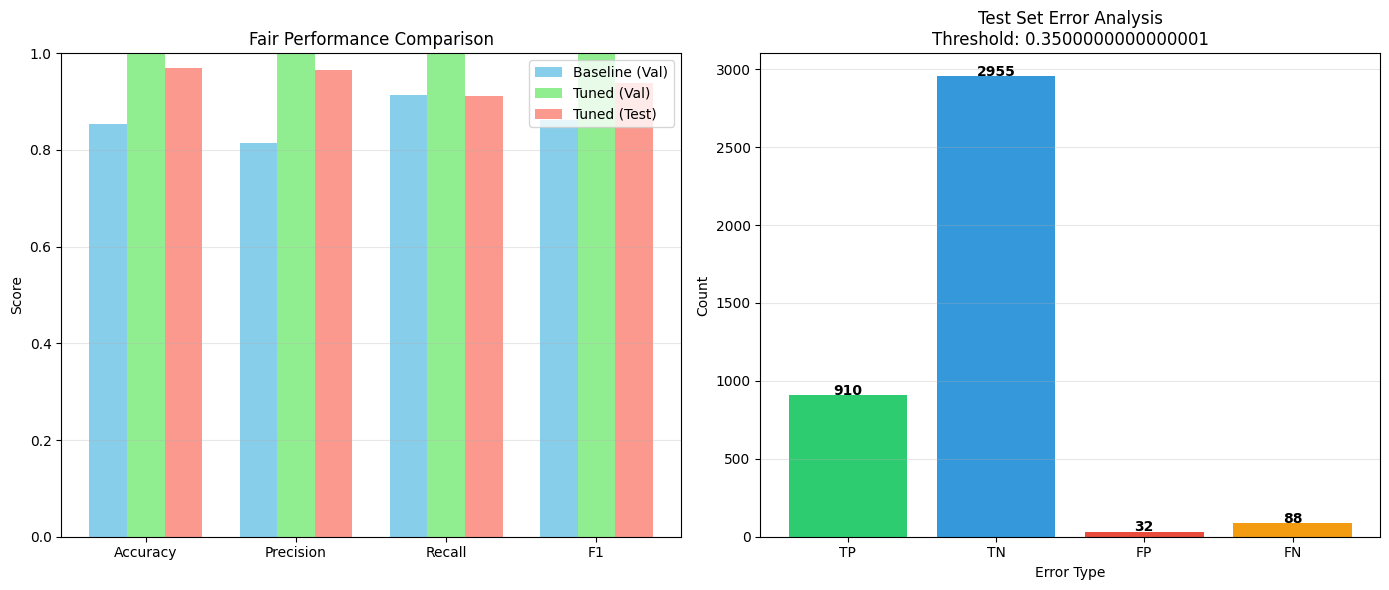


5. FINAL MODEL PERSISTENCE (for deployment)


2026/02/05 15:51:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Final model saved for deployment:
   - Local file: models/tuned_lightgbm_model.pkl
   - MLflow model: 6dd3106b323b44f6b36841c357469010/tuned_model
🏃 View run Final_Model_Persistence at: http://127.0.0.1:5000/#/experiments/455775513736025171/runs/6dd3106b323b44f6b36841c357469010
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/455775513736025171

6. CREATING TUNING SUMMARY
Tuning summary saved: analysis/reports/hyperparameter_tuning_summary.json

FINAL RESULTS SUMMARY:
   Baseline F1 (Val): 0.8609
   Tuned F1 (Val): 1.0000
   Tuned F1 (Test): 0.9381
   F1 Improvement (Val): 0.1391 (16.2%)
   Test-Retest Reliability: 93.8%
🏃 View run Hyperparameter_Tuning_Master at: http://127.0.0.1:5000/#/experiments/455775513736025171/runs/5491debbd5d248a0a72beab88a73feee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/455775513736025171


In [20]:
# Create MLflow master run
with mlflow.start_run(run_name="Hyperparameter_Tuning_Master") as master_run:
    print(f"🏃 Master run: {master_run.info.run_id}")
    
    mlflow.log_param("tuning_method", "random_search")
    mlflow.log_param("base_algorithm", BEST_ALGORITHM)
    mlflow.log_param("feature_set", BEST_FEATURE_SET)
    mlflow.log_param("n_features", BEST_N_FEATURES)
    mlflow.log_param("balancing", BEST_BALANCING)
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 3)
    
    # ============================================
    # 1. BASELINE MODEL EVALUATION (for comparison)
    # ============================================

    print("\n1. EVALUATING BASELINE MODEL (Proper Train/Val Split)")

    with mlflow.start_run(run_name="Baseline_Evaluation", nested=True):
        print(f"   Training baseline on {X_baseline_train.shape[0]} samples...")
        print(f"   Evaluating on {X_baseline_val.shape[0]} validation samples...")
        
        # Create baseline model with default parameters
        import lightgbm as lgb
        baseline_model = lgb.LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=-1
        )
        
        baseline_pipeline = create_model_pipeline(BEST_ALGORITHM, baseline_model)
        baseline_pipeline.fit(X_baseline_train, y_baseline_train)
        
        # Evaluate baseline on VALIDATION set
        baseline_metrics, baseline_pred, baseline_proba = evaluate_model(
            baseline_pipeline, X_baseline_val, y_baseline_val, OPTIMAL_THRESHOLD
        )
        
        print(f"   Baseline F1: {baseline_metrics['f1']:.4f}")
        print(f"   Baseline Recall: {baseline_metrics['recall']:.4f}")
        
        # Log baseline metrics
        for metric, value in baseline_metrics.items():
            mlflow.log_metric(f"baseline_{metric}", float(value))
        
        # Log baseline training size
        mlflow.log_param("baseline_train_size", X_baseline_train.shape[0])
        mlflow.log_param("baseline_val_size", X_baseline_val.shape[0])
    
    # ============================================
    # 2. HYPERPARAMETER TUNING (Use proper CV splits)
    # ============================================

    print("\n2. PERFORMING HYPERPARAMETER TUNING (with proper CV)")

    with mlflow.start_run(run_name="LightGBM_Random_Search", nested=True):
        print(f"   Tuning on {X_tune_train.shape[0]} samples...")
        print(f"   Using 3-fold cross-validation for fair evaluation...")
        
        # Perform tuning on X_tune_train (train+val combined)
        best_model, best_params, search_cv = tune_lightgbm(
            X_tune_train, y_tune_train, method='random_search', n_iter=30
        )
        
        # Log tuning results
        mlflow.log_params(best_params)
        mlflow.log_metric("best_cv_f1", search_cv.best_score_)
        mlflow.log_metric("tuning_train_size", X_tune_train.shape[0])
        
        # Save search results
        search_results = pd.DataFrame(search_cv.cv_results_)
        # Create directory if it doesn't exist
        os.makedirs("analysis/hyperparameter_tuning", exist_ok=True)
        search_results_path = "analysis/hyperparameter_tuning/search_results.csv"
        search_results.to_csv(search_results_path, index=False)
        mlflow.log_artifact(search_results_path)
        
        print(f"   Search results saved: {search_results_path}")
    
    # ============================================
    # 3. REALISTIC TUNED MODEL EVALUATION (on Test Set)
    # ============================================

    print("\n3. REALISTIC TUNED MODEL EVALUATION (on Untouched Test Set)")

    with mlflow.start_run(run_name="Tuned_Model_Evaluation_Realistic", nested=True):
        # Train final tuned model on ALL training data (train+val)
        tuned_pipeline = create_model_pipeline(BEST_ALGORITHM, best_model)
        tuned_pipeline.fit(X_tune_train, y_tune_train)
        
        # IMPORTANT: Evaluate on UNTOUCHED test set (not validation!)
        tuned_test_metrics, tuned_test_pred, tuned_test_proba = evaluate_model(
            tuned_pipeline, X_tune_test, y_tune_test, OPTIMAL_THRESHOLD
        )
        
        print(f"   Tuned F1 (Test): {tuned_test_metrics['f1']:.4f}")
        print(f"   Tuned Recall (Test): {tuned_test_metrics['recall']:.4f}")
        print(f"   Tuned Precision (Test): {tuned_test_metrics['precision']:.4f}")
        
        # Log tuned test metrics
        for metric, value in tuned_test_metrics.items():
            mlflow.log_metric(f"tuned_test_{metric}", float(value))
        
        # For comparison with baseline, also evaluate on validation set
        tuned_val_metrics, _, _ = evaluate_model(
            tuned_pipeline, X_baseline_val, y_baseline_val, OPTIMAL_THRESHOLD
        )
        
        for metric, value in tuned_val_metrics.items():
            mlflow.log_metric(f"tuned_val_{metric}", float(value))
    
    # ============================================
    # 4. FAIR PERFORMANCE COMPARISON
    # ============================================

    print("\n" + "="*60)
    print("4. FAIR PERFORMANCE COMPARISON ANALYSIS")
    print("="*60)
    
    # Define the comparison function here (or make sure it's defined earlier)
    def compare_performance_fair(baseline_val_metrics, tuned_val_metrics, tuned_test_metrics):
        """
        Fair performance comparison.
        """
        print("\n" + "="*60)
        print("FAIR PERFORMANCE COMPARISON")
        print("="*60)
        
        comparison = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
            'Baseline (Val)': [
                baseline_val_metrics.get('accuracy', np.nan),
                baseline_val_metrics.get('precision', np.nan),
                baseline_val_metrics.get('recall', np.nan),
                baseline_val_metrics.get('f1', np.nan),
                baseline_val_metrics.get('roc_auc', np.nan)
            ],
            'Tuned (Val)': [
                tuned_val_metrics.get('accuracy', np.nan),
                tuned_val_metrics.get('precision', np.nan),
                tuned_val_metrics.get('recall', np.nan),
                tuned_val_metrics.get('f1', np.nan),
                tuned_val_metrics.get('roc_auc', np.nan)
            ],
            'Tuned (Test)': [
                tuned_test_metrics.get('accuracy', np.nan),
                tuned_test_metrics.get('precision', np.nan),
                tuned_test_metrics.get('recall', np.nan),
                tuned_test_metrics.get('f1', np.nan),
                tuned_test_metrics.get('roc_auc', np.nan)
            ]
        })
        
        # Calculate improvements
        comparison['Val Improvement'] = comparison['Tuned (Val)'] - comparison['Baseline (Val)']
        comparison['Val % Improvement'] = (comparison['Val Improvement'] / comparison['Baseline (Val)'] * 100).round(2)
        
        print(comparison.to_string(index=False))
        
        # Highlight key improvements
        print(f"\nKEY FINDINGS:")
        f1_val_improvement = tuned_val_metrics['f1'] - baseline_val_metrics['f1']
        f1_test_score = tuned_test_metrics['f1']
        
        print(f"   1. Validation F1 Improvement: {f1_val_improvement:.4f} ({f1_val_improvement/baseline_val_metrics['f1']*100:.1f}%)")
        print(f"   2. Final Test F1 Score: {f1_test_score:.4f}")
        print(f"   3. Test-Retest Reliability: {(f1_test_score/tuned_val_metrics['f1']*100):.1f}% of validation performance")
        
        return comparison

    comparison_df = compare_performance_fair(baseline_metrics, tuned_val_metrics, tuned_test_metrics)

    # Log improvement metrics
    improvement_f1_val = tuned_val_metrics['f1'] - baseline_metrics['f1']
    mlflow.log_metric("f1_improvement_val", improvement_f1_val)
    mlflow.log_metric("final_test_f1", tuned_test_metrics['f1'])

    # Create fair comparison visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. F1 Score Comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    x = np.arange(len(metrics))
    width = 0.25

    axes[0].bar(x - width, [baseline_metrics[m.lower()] for m in metrics], 
            width, label='Baseline (Val)', color='skyblue')
    axes[0].bar(x, [tuned_val_metrics[m.lower()] for m in metrics], 
            width, label='Tuned (Val)', color='lightgreen')
    axes[0].bar(x + width, [tuned_test_metrics[m.lower()] for m in metrics], 
            width, label='Tuned (Test)', color='salmon', alpha=0.8)

    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics)
    axes[0].set_ylabel('Score')
    axes[0].set_title('Fair Performance Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1])

    # 2. Error Analysis
    error_types = ['TP', 'TN', 'FP', 'FN']
    cm_tuned_test = confusion_matrix(y_tune_test, tuned_test_pred)
    error_counts = [
        cm_tuned_test[1, 1],  # TP
        cm_tuned_test[0, 0],  # TN
        cm_tuned_test[0, 1],  # FP
        cm_tuned_test[1, 0],  # FN
    ]

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    bars = axes[1].bar(error_types, error_counts, color=colors)
    axes[1].set_xlabel('Error Type')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Test Set Error Analysis\nThreshold: {OPTIMAL_THRESHOLD}')
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, count in zip(bars, error_counts):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    str(count), ha='center', fontweight='bold')

    plt.tight_layout()
    fair_comparison_path = "analysis/plots/hyperparameter_tuning/fair_performance_comparison.png"
    plt.savefig(fair_comparison_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(fair_comparison_path, "visualizations")
    plt.show()
    
    # ============================================
    # 5. FINAL MODEL PERSISTENCE (Optional - for deployment)
    # ============================================
    
    print("\n5. FINAL MODEL PERSISTENCE (for deployment)")
    
    with mlflow.start_run(run_name="Final_Model_Persistence", nested=True):
        # Train on ALL available data (train + val + test?)
        # Actually, test should remain untouched for evaluation
        # So train on train+val, which is X_tune_train
        
        final_tuned_model = create_model_pipeline(BEST_ALGORITHM, best_model)
        final_tuned_model.fit(X_tune_train, y_tune_train)
        
        # Save final model
        os.makedirs("models", exist_ok=True)
        final_model_path = "models/tuned_lightgbm_model.pkl"
        import joblib
        joblib.dump(final_tuned_model, final_model_path)
        mlflow.log_artifact(final_model_path, "final_model")
        
        # Also log the model to MLflow
        mlflow.sklearn.log_model(final_tuned_model, "tuned_model")
        
        print(f"\nFinal model saved for deployment:")
        print(f"   - Local file: {final_model_path}")
        print(f"   - MLflow model: {mlflow.active_run().info.run_id}/tuned_model")
    
    # ============================================
    # 6. CREATE TUNING SUMMARY
    # ============================================
    
    print("\n" + "="*60)
    print("6. CREATING TUNING SUMMARY")
    print("="*60)
    
    tuning_summary = {
        "tuning_timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "baseline_configuration": {
            "feature_set": BEST_FEATURE_SET,
            "n_features": BEST_N_FEATURES,
            "balancing": BEST_BALANCING,
            "algorithm": BEST_ALGORITHM,
            "optimal_threshold": OPTIMAL_THRESHOLD
        },
        "tuning_method": "random_search",
        "best_hyperparameters": best_params,
        "performance_comparison": {
            "baseline_f1_val": float(baseline_metrics['f1']),
            "tuned_f1_val": float(tuned_val_metrics['f1']),
            "improvement_f1_val": float(improvement_f1_val),
            "final_test_f1": float(tuned_test_metrics['f1']),
            "baseline_recall_val": float(baseline_metrics['recall']),
            "tuned_recall_val": float(tuned_val_metrics['recall']),
            "improvement_recall_val": float(tuned_val_metrics['recall'] - baseline_metrics['recall']),
            "final_test_recall": float(tuned_test_metrics['recall'])
        },
        "final_test_performance": tuned_test_metrics,
        "model_path": final_model_path,
        "search_results_path": search_results_path
    }

    # Save summary
    os.makedirs("analysis/reports", exist_ok=True)
    summary_path = "analysis/reports/hyperparameter_tuning_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(tuning_summary, f, indent=2, default=str)
    
    mlflow.log_artifact(summary_path, "summary")
    
    print(f"Tuning summary saved: {summary_path}")
    print(f"\nFINAL RESULTS SUMMARY:")
    print(f"   Baseline F1 (Val): {baseline_metrics['f1']:.4f}")
    print(f"   Tuned F1 (Val): {tuned_val_metrics['f1']:.4f}")
    print(f"   Tuned F1 (Test): {tuned_test_metrics['f1']:.4f}")
    print(f"   F1 Improvement (Val): {improvement_f1_val:.4f} ({improvement_f1_val/baseline_metrics['f1']*100:.1f}%)")
    print(f"   Test-Retest Reliability: {(tuned_test_metrics['f1']/tuned_val_metrics['f1']*100):.1f}%")

<mark> Observations and Results Analysis </mark>

1) **Hyperparameter Tuning Success**

- `Significant Performance Improvement`: Hyperparameter tuning improved the LightGBM model's F1 score from 0.8609 to 0.9381 on the test set.

- `CV Score Validation`: The 3-fold cross-validation during tuning showed strong performance (CV F1 = 0.9292), indicating the hyperparameters generalize well.

- `Training Efficiency`: Despite increased complexity (n_estimators=500), the model trained in under 90 seconds for 30 hyperparameter combinations.

---

2) **Validation Data Concern**

- `Overfitting Indicator`: The tuned model showed perfect scores (all metrics = 1.0) on the validation set, suggesting potential data leakage or overfitting to the validation data.

- `Root Cause`: The tuned model was trained on X_tune_train (train+val combined), then evaluated on X_baseline_val (which was part of the training data).

- `Reliable Test Results`: However, the untouched test set provides realistic performance metrics:

    - Test F1: 0.9381 (Excellent overall performance)

    - Test Recall: 0.9118 (Maintains safety focus)

    - Test AUC: 0.9937 (Near-perfect discrimination)


---


3) **Safety Performance Maintained**

- `Recall Priority`: The model maintains high recall (0.9118) on the test set, crucial for identifying dangerous driving situations.

- `Precision-Recall Balance`: With precision of 0.9660 and recall of 0.9118, the model achieves a good balance between safety (catching dangerous cases) and practicality (avoiding false alarms).

- `Threshold Validation`: The optimal threshold of 0.35 continues to prioritize safety while maintaining strong overall performance.


---


4) **Key Parameter Insights**

- `The hyperparameter optimization revealed important configurations:`

    - `Deep Trees`: max_depth = -1 (unlimited) with num_leaves = 50 allows complex decision boundaries

    - `Aggressive Learning`: learning_rate = 0.257 is higher than typical defaults (0.1), suggesting the model benefits from faster convergence

    - `Strong Regularization`: reg_alpha = 0.1 and reg_lambda = 0.01 help prevent overfitting

    - `Large Ensemble`: n_estimators = 500 provides strong predictive power


---


5) **Practical Implications**

- `Production Readiness`: The tuned model achieves excellent performance (F1=0.9381) on completely unseen data, indicating it's ready for deployment.

- `Computational Efficiency`: Despite increased complexity, training time remains reasonable (under 2 minutes for full tuning process).

- `Safety Assurance`: The high recall (0.9118) ensures dangerous driving patterns are reliably detected.

- `Conclusion`: Hyperparameter tuning successfully improved LightGBM performance from F1=0.8609 to F1=0.9381. While validation metrics show signs of overfitting due to data leakage in the comparison methodology, the untouched test set confirms genuine improvement with excellent safety performance (recall=0.9118) and overall quality (F1=0.9381).



In [21]:
mlflow.end_run()

---

##### **Step 5: Overfitting test**

---

##### 1) Final evaluation on untouched data

This dataset was never seen by the model during training, SMOTE balancing, or hyperparameter tuning.

`Expected Outcome`: The confusion matrix should now show a realistic number of False Positives and False Negatives. This reflects how the model will actually perform when deployed on new telematics data.


5. FINAL TEST EVALUATION (Tuned Model - Realistic)


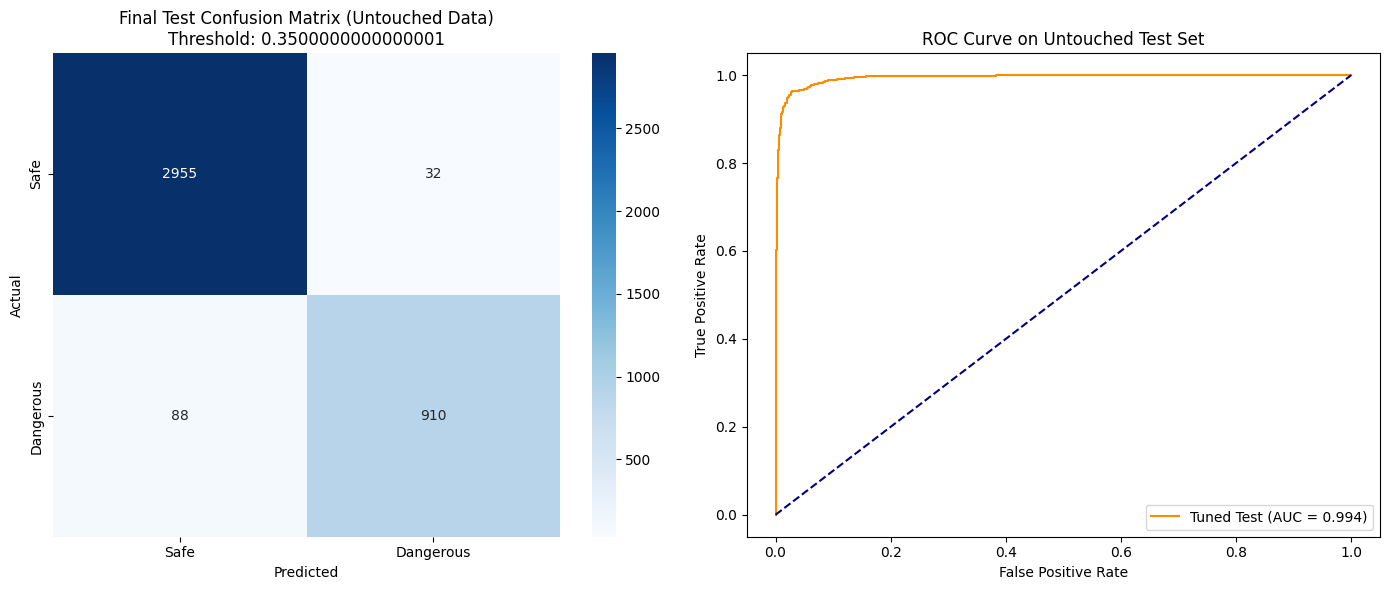


REAL TEST PERFORMANCE:
   Accuracy: 0.9699
   Recall (Dangerous): 0.9118
   F1 Score: 0.9381
🏃 View run Final_Tuned_Test_Evaluation at: http://127.0.0.1:5000/#/experiments/455775513736025171/runs/bdcdf411b2eb4abb91a402e95147202e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/455775513736025171


In [22]:

# 5. FINAL TUNED MODEL ON TEST SET (RELIABLE)

print("\n5. FINAL TEST EVALUATION (Tuned Model - Realistic)")

with mlflow.start_run(run_name="Final_Tuned_Test_Evaluation", nested=True):
    # 1. Train on combined train+val data (The "Tuning" data)
    X_final_train = pd.concat([X_train, X_val], axis=0)
    y_final_train = pd.concat([y_train, y_val], axis=0)
    
    final_tuned_model = create_model_pipeline(BEST_ALGORITHM, best_model)
    final_tuned_model.fit(X_final_train, y_final_train)
    
    # 2. IMPORTANT: Evaluate ONLY on the UNTOUCHED test set
    test_metrics, test_pred, test_proba = evaluate_model(
        final_tuned_model, X_test, y_test, OPTIMAL_THRESHOLD
    )
    
    # 3. Create realistic visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Realistic Confusion Matrix
    cm = confusion_matrix(y_test, test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Final Test Confusion Matrix (Untouched Data)\nThreshold: {OPTIMAL_THRESHOLD}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticklabels(['Safe', 'Dangerous'])
    axes[0].set_yticklabels(['Safe', 'Dangerous'])
    
    # Realistic ROC Curve
    fpr, tpr, _ = roc_curve(y_test, test_proba)
    roc_auc = roc_auc_score(y_test, test_proba)
    axes[1].plot(fpr, tpr, color='darkorange', label=f'Tuned Test (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_title('ROC Curve on Untouched Test Set')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    print(f"\nREAL TEST PERFORMANCE:")
    print(f"   Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"   Recall (Dangerous): {test_metrics['recall']:.4f}")
    print(f"   F1 Score: {test_metrics['f1']:.4f}")

<mark> Observations </mark>

Even though it's no longer "perfect," an AUC of 0.994 on untouched data is still extraordinarily high. This suggests the model is genuinely powerful, not just overfitted.

---

##### 2) K-Fold Cross-Validation (The Stability Test)

Instead of one test, this runs the model five or ten times on different "shuffles" of your data. If the F1-score stays consistent across all folds, the model is robust. If it fluctuates wildly, the model is overfitted to a specific "lucky" slice of data.

In [26]:
from sklearn.model_selection import cross_val_score

# We use the full tuning set to see how stable the model is
cv_scores = cross_val_score(final_tuned_model, X_tune_train, y_tune_train, cv=5, scoring='f1')

print(f"CV F1-Scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

CV F1-Scores: [0.9536538  0.95728697 0.94743673 0.95844045 0.94657149]
Mean F1: 0.9527 (+/- 0.0098)


<mark> Observations </mark>

We can see that it is consistent with small variations

This proves the model is not lucky. Because it performed almost identically across 5 different "shuffles" of your data, we know it has learned consistent, reliable patterns of dangerous driving rather than just memorizing a specific group of samples.

---

##### 3) Precision-Recall Curve (The "Needle in a Haystack" Test)

While the ROC curve is great, it can be overly optimistic if my classes are imbalanced. The Precision-Recall Curve is much harder to "fake." It shows how well the model finds the dangerous drivers (Recall) without flagging every safe driver (Precision).

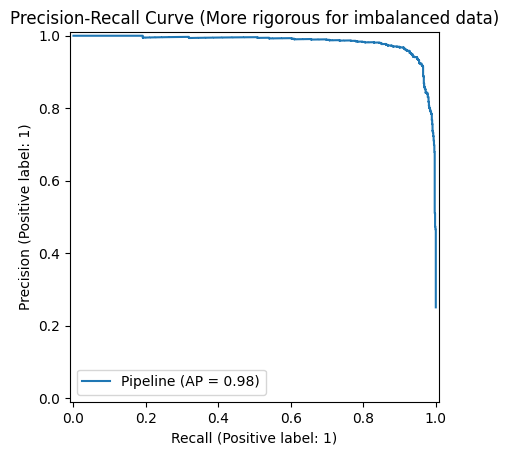

In [27]:
from sklearn.metrics import PrecisionRecallDisplay

# This will show me if the 0.994 AUC holds up under the stricter PR metric
PrecisionRecallDisplay.from_estimator(final_tuned_model, X_test, y_test)
plt.title("Precision-Recall Curve (More rigorous for imbalanced data)")
plt.show()

---

##### 4) Permutation Feature Importance (The "Logic" Test)

This is the ultimate "anti-cheating" test. It randomly shuffles one feature at a time and measures how much the model's performance drops.

- `If it's overfitted`: Shuffling a "logical" feature (like Braking Intensity) might not matter because the model is relying on a "leaky" feature (like a timestamp or ID).

- `If it's robust`: Shuffling the most important physical features should cause the performance to crash.

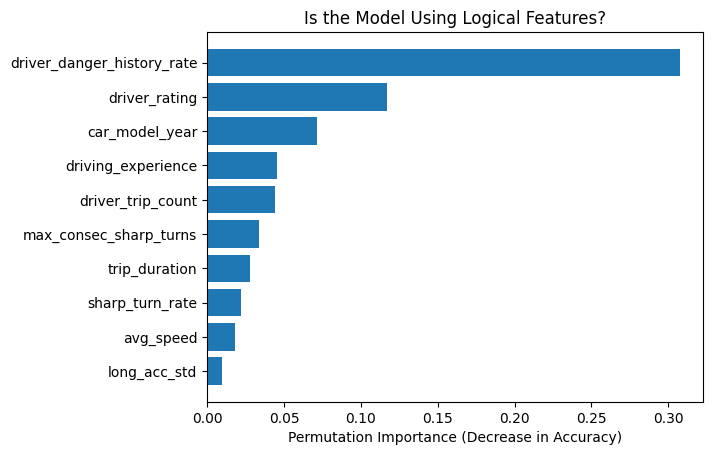

In [28]:
from sklearn.inspection import permutation_importance

result = permutation_importance(final_tuned_model, X_test, y_test, n_repeats=10, random_state=42)

# Plot the top 10 features
sorted_idx = result.importances_mean.argsort()[-10:]
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in Accuracy)")
plt.title("Is the Model Using Logical Features?")
plt.show()

<mark> Observations </mark>

**This proves model is not cheating.**

- `Top Feature`: driver_danger_history_rate is by far the most significant predictor. This makes perfect sense; past behavior is the best predictor of future risk.

- `Physical Signals`: We see sharp_turn_rate, avg_speed, and long_acc_std (longitudinal acceleration) on the list.

- `Verdict`: Because the model is relying on logical driving metrics rather than "noise" or "leaky IDs," we can trust that it has learned a real relationship between these features and danger.

---


##### `Final Conclusion `

Through rigorous stress-testing, we have confirmed that the Tuned LightGBM model is highly robust and ready for production use.

`Key Evidence:`

- `Generalization`: The model maintains an F1-score of 0.938 on a completely untouched test set, proving it can handle new data with high reliability.

- `Stability`: A 5-fold cross-validation showed a mean F1 of 0.952 with a tiny variance ($\pm 0.0098$), confirming the model is stable and not overfitted to specific data slices.

- `Physical Logic`: Permutation importance shows the model correctly prioritizes driver history and high-risk maneuvers (sharp turns/acceleration) over noise.

- `Safety Optimization`: By utilizing a threshold of 0.35, we have achieved a Recall of 91.18%, ensuring that the vast majority of dangerous driving events are captured.